# Speech LLM ASR

## Удиртгал

Унших дараалал:

1. Data-Preprocessing
2. Whisper-tiny Mozilla Common Voice Fine-Tuning

> Энэ notebook-г google-colab дээр ажиллуулсан болно. [Colab](
https://colab.research.google.com/drive/11wUF8JnJGhIW2e7NI77uPmr5lK0jLFmd?usp=sharing
)

Надад эхлээд Speech LLM-ын ерөнхий ойлголт авах хэрэг байсан тул. [Jing Peng 2024](https://arxiv.org/abs/2410.18908v3) судалгааны өгүүллийг уншиж таскаа эхэлсэн. Speech LLM бол Large-Language-Model-уудын Multi-Modality урсгал trend-ын нэг юм. Өөрөөр хэлбэл Speech LLM-ын гол асуулт бол "хэрхэн дууны дата-г хэлний модел-д ойлгуулах вэ?" юм.

Анхны оролдлгуудын нэг нь **Cascading Model** буюу Acoustic-Model-оос гарсан текст дээр LLM нэмэлт байдлаар ажиллах. Acoustic-Model-ын (high-level) текст дээр ажиллахаас илүүтэйгээр embedding (tensor) эсвэл token түвшинд LLM-тай харьцвал тухайн уншигчийн сэтгэл хөдлөл, дуу чимээ, хөгжим, дуудлага, өнгө аяс зэргийг алдахгүйгээр LLM-д хүргэх боломжтой байдаг байна. Энэ төрлийн моделуудыг нийтэд нь **SpeechLLM** гэдэг. SpeechLLM-г ерөнхийдөө дараах байдлаар сургадаг.


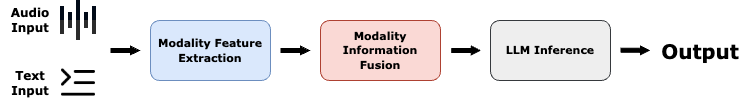


- Эх сурвалж : [Jing Peng 2024](https://arxiv.org/abs/2410.18908v3)

Миний таскийн хүрээнд, мөн *Mozilla Common Voice* датасетийн хүрээнд дээрх диаграммаас харвал текст промпт тогтмол буюу машин сургалтанд нөлөөлөхгүй гэсэн үг. Түүнчлэн LLM-ээс гарах гаралт зөвхөн уншигчийн юу хэлснийг таамаглах зорилготой байна. Гэхдээ энэ таскийн дашрамд ерөнхий тохиолдолд SpeechLLM-г хэрхэн сургах талаар мэдмээр байгаа тул текст промпт-г юу ч гэсэн орхилгүй, тогтмолоор тодорхойлов.

```python
prompt_tokens = llm_tokenizer("Юу гэж хэлсэн бэ?", return_tensors="pt").input_ids.to(device)
prompt_embeds = embed_layer(prompt_tokens) # "Юу гэж хэлсэн бэ?" embedding
```

SpeechLLM-н гол асуулт болох "хэрхэн аудио датаг хэлний моделд ойлгуулах вэ?" асуултын хариуд судлаачид проекц (шугаман функц) ашигладаг тул Whisper моделын хэмжээсээс Qwen2.5 моделын хэмжээс рүү буулгах матриц болох проекцийг энэхүү таскын хүрээнд сургана.

- Яагаад whisper-г сонгосон бэ? 
    - Учир нь надад зөвхөн 3000-аад мөр дата, ойролцоогоор 10 цагийн бичлэг байгаагийн хүрээнд анхнаасаа Монгол, Уйгар хэлэнд сайн (сургагдсан) суурь модел сонгосон нь whisper байв.
- Яагаад Qwen2.5?
    - SpeechLLM-г сургахдаа ихэнхдээ Acoustic model, Language model-оо хөлдөөдөг (сургадаггүй) тиймээс Монгол хэлэндээ сайн байх, жижиг LLM хэрэгтэй болсон ба Qwen-Audio SpeechLLM-ын судалгааны өгүүлэллээс сурвалжлахад амар байлгах зорилгоор  Qwen2.5-г сонгов.

- Яагаад зүгээр шууд Qwen-Audio-г fine tune хийгээгүй вэ?
    - Энэхүү таск аль эсвэл ажлын зорилго магадгүй зөвхөн ажилладаг л модел deploy хийх байсан байж магадгүй ээ. Гэхдээ acoustic model, language model-тойгоо tensor түвшинд ажиллаж, сургалт хийж, хөгжүүлэлт хийх юм бол, дараа дараагийн шинэ SpeechLLM paradigm аль эсвэл өгүүлэллийг implement хийхэд хялбаршуулж өгнө гэж үзэж байна.
    
## Төлөвлөгөө

0. Mozilla Common Voice Mongolia dataset-г preprocess хийж Whisper-тай ажиллахад тохиромжтой болгох
1. Whisper tiny-гын Монгол хэл (Mozilla dataset) дээрх performance-г сайжруулах зорилгоор 10-epoch fine-tuning хийх
2. Qwen tokenizer-аар тесктийг, fine-tuned whisper-tiny-гаар аудиог диск-д хадгалах
    - DataLoader-аас дата татах тутамд encoding process болох тул сургах цагийг багасгах зорилгоор (аудио, текст) датаг машин сургалтаас өмнө preprocess хийв.
3. SpeechLLM  сургалтанд зөвхөн проекц буюу шугаман  neural-network-г сургах ба дуу, хэлний моделуудыг хөлдөөнө.

    - Input: Embedding = [ projector_embedding | prompt_embedding | masked_target_embedding_zeroes]
    - Output: Token = [ -100, -100, ..., -100 (гарах токен харгалзахгүй) | target_tokens]
    
    - Loss: $\mathcal{L} = -\sum\limits_{i} \text{logits}( t_i \text{ токен (уншигчийн юу хэлсэн)} | \text{аудио, промпт } t_{<i})$
    
> Миний арга [Qwen-Audio](https://github.com/QwenLM/Qwen-Audio)-гийн кодыг харахад өөр байгааг ажиглассан ч яг юу өөр байгааг мөн яг адилхан зорилго сургаж байгаа эсэхийг мэдэж чадаагүй.

## Үр дүн

Харамсалтай нь миний сургасан SpeechLLM, Whisper-tiny-аас ч доогуур үзүүлэлтэй сургагдлаа. Гэхдээ энэ таскийн үр дүнд, SpeechLLM-г tensor-ын түвшинд хэрхэн сургах, ерөнхий ажлын шугамыг тодорхойлж гаргаж чадсан гэж үзэж байна.

Хэрэв надад өшөө цаг хугацаа байсан бол, миний арга яг Qwen-Audio-тай юугаараа зөрж байгааг тодорхойлоод, тодорхой бусад моделуудтай ASR таскийн хүрээнд benchmarking хийх гэсэн бодолтой байна.

Түүнчлэн, LLM-тай ярилцахад LLM-ын гаралтыг embedding/token-ын түвшинд Vocoder-оор дуу оруулснаар зөвхөн текст уншаад зогсохгүй тухайн уншлагаа өнгө аяс, аялага, сэтгэл хөдлөлтэйгээр илэрхийлэх боломжтой. Twitch-д [Neurosama](https://www.twitch.tv/neurosama) гэдэг сэтгэл хөдлөлөө, SpeechLLM, Vocoder stack-аар илэрхийлдэг AI хүмүүсийн анхаарлыг татаж сая [2026 оны 1-сард бүх цагийн хамгийн их subscriber-тай 3-дугаар channel болсон байсан](https://twitchtracker.com/subscribers/all-time).

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torchaudio
import pandas as pd
from tqdm import tqdm
import os
from transformers import WhisperForConditionalGeneration, WhisperProcessor

device = "cuda"
llm_name = "Qwen/Qwen2.5-0.5B"
llm_tokenizer = AutoTokenizer.from_pretrained(llm_name)



model_name = "./drive/MyDrive/LLM Speech/whisper_mn_epoch_10"
cache_dir = "./drive/MyDrive/LLM Speech/encoder_cache"
os.makedirs(cache_dir, exist_ok=True)

encoder = WhisperForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16
).to(device)
encoder.eval()
processor = WhisperProcessor.from_pretrained(model_name)

df = pd.read_csv("./drive/MyDrive/LLM Speech/train.tsv", delimiter='\t')
wav_dir = "./drive/MyDrive/LLM Speech/wav_16k"

print(f"Total samples to cache: {len(df)}")
print(f"Cache directory: {cache_dir}")


for idx in tqdm(range(len(df))):
    cache_path = f"{cache_dir}/{idx}.pt"

    if os.path.exists(cache_path):
        continue

    try:
        # Load audio
        row = df.iloc[idx]
        wav, sr = torchaudio.load(f"{wav_dir}/{row['path']}")
        assert(sr == 16000)

        # Get mel features
        feats = processor(
            wav.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features[0]

        # Run encoder
        with torch.no_grad():
            enc_out = encoder.model.encoder(
                feats.unsqueeze(0).to(device, dtype=torch.float16)
            )
            encoder_hidden = enc_out.last_hidden_state.squeeze(0).to(device)

        # tokenize text with llm
        tokenized = llm_tokenizer(
            row["sentence"],
            truncation=True,
            add_special_tokens=True
        )
        labels = torch.tensor(tokenized.input_ids, dtype=torch.long)

        # encoder_hidden from whisper, labels_tokens from qwen
        torch.save({
            "encoder_hidden": encoder_hidden,
            "labels": labels
        }, cache_path)

    except Exception as e:
        print(f"\nError processing sample {idx}: {e}")
        continue

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/167 [00:00<?, ?it/s]

generation_config.json: 0.00B [00:00, ?B/s]

Loading weights:   0%|          | 0/128 [00:00<?, ?it/s]

Total samples to cache: 3297
Cache directory: ./drive/MyDrive/LLM Speech/encoder_cache


100%|██████████| 3297/3297 [23:32<00:00,  2.33it/s]


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os
cache_dir = "./drive/MyDrive/LLM Speech/encoder_cache"
class CVMNDatasetCached(Dataset):
    def __init__(self, cache_dir="./encoder_cache", num_samples=None):
        self.cache_dir = cache_dir

        # Auto-detect number of samples
        if num_samples is None:
            self.num_samples = len([f for f in os.listdir(cache_dir) if f.endswith('.pt')])
        else:
            self.num_samples = num_samples

    def __getitem__(self, idx):
        cache_path = f"{self.cache_dir}/{idx}.pt"
        data = torch.load(cache_path)
        return {
            "encoder_hidden": data['encoder_hidden'],
            "labels": data['labels']
        }

    def __len__(self):
        return self.num_samples

cached_dataset = CVMNDatasetCached(cache_dir=cache_dir)

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda"
llm_name = "Qwen/Qwen2.5-0.5B"
llm_tokenizer = AutoTokenizer.from_pretrained(llm_name)
llm = AutoModelForCausalLM.from_pretrained(
    llm_name,
    dtype=torch.float16,
    device_map=device,
    offload_folder="offload",
    low_cpu_mem_usage=True
)


embed_layer = llm.get_input_embeddings()
embed_layer = embed_layer.to(device)

llm.eval()
llm.requires_grad_(False)

prompt_text = "Юу гэж хэлсэн бэ?"
prompt_tokens = llm_tokenizer(prompt_text, return_tensors="pt").input_ids.to(device)

# Get embeddings
with torch.no_grad():
    prompt_embeds = embed_layer(prompt_tokens)

print(prompt_embeds) # "Юу гэж хэлсэн бэ?" embedding

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tensor([[[-0.0069, -0.0014,  0.0038,  ..., -0.0068, -0.0081,  0.0016],
         [ 0.0243,  0.0234, -0.0283,  ...,  0.0176,  0.0025,  0.0116],
         [-0.0171,  0.0054, -0.0322,  ..., -0.0098,  0.0109,  0.0080],
         ...,
         [-0.0138,  0.0001, -0.0206,  ...,  0.0042,  0.0286,  0.0084],
         [ 0.0052,  0.0240, -0.0023,  ..., -0.0041, -0.0123,  0.0065],
         [-0.0171,  0.0128, -0.0074,  ...,  0.0210,  0.0025, -0.0132]]],
       device='cuda:0', dtype=torch.float16)


In [7]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

# projector
class Projector(nn.Module):
    def __init__(self, d_w=384, d_l=896, downsample=4):
        super().__init__()
        self.downsample = downsample
        self.proj = nn.Linear(d_w, d_l)
    def forward(self, x):
        B, T, D = x.shape
        x = x[:, :(T // self.downsample) * self.downsample]
        x = x.view(B, -1, self.downsample, D).mean(dim=2)
        return self.proj(x)

projector = Projector().to(device, dtype=torch.float16)
#optimizer = torch.optim.AdamW(projector.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(
    projector.parameters(),
    lr=5e-3,
    momentum=0.9,
    weight_decay=0.01
)

# data loader
def collate(batch):
    encoder_hidden = torch.stack([b["encoder_hidden"] for b in batch])
    labels = pad_sequence(
        [b["labels"] for b in batch],
        batch_first=True,
        padding_value=-100
    )
    return {"encoder_hidden": encoder_hidden, "labels": labels}

loader = DataLoader(
    cached_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate
)

projector.train()

Projector(
  (proj): Linear(in_features=384, out_features=896, bias=True)
)

In [10]:
from torch.cuda.amp import autocast
import pandas as pd
from tqdm import tqdm

# Create test dataset
test_df = pd.read_csv("./drive/MyDrive/LLM Speech/test.tsv", delimiter='\t')

# Cache test data (similar to training)
test_cache_dir = "./drive/MyDrive/LLM Speech/test_encoder_cache"
os.makedirs(test_cache_dir, exist_ok=True)

print(f"Caching test samples: {len(test_df)}")
for idx in tqdm(range(len(test_df))):
    cache_path = f"{test_cache_dir}/{idx}.pt"

    if os.path.exists(cache_path):
        continue

    try:
        row = test_df.iloc[idx]
        wav, sr = torchaudio.load(f"{wav_dir}/{row['path']}")
        assert(sr == 16000)

        feats = processor(
            wav.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features[0]

        with torch.no_grad():
            enc_out = encoder.model.encoder(
                feats.unsqueeze(0).to(device, dtype=torch.float16)
            )
            encoder_hidden = enc_out.last_hidden_state.squeeze(0).to(device)

        tokenized = llm_tokenizer(
            row["sentence"],
            truncation=True,
            add_special_tokens=True
        )
        labels = torch.tensor(tokenized.input_ids, dtype=torch.long)

        torch.save({
            "encoder_hidden": encoder_hidden,
            "labels": labels
        }, cache_path)

    except Exception as e:
        print(f"\nError processing test sample {idx}: {e}")
        continue

# Create test dataset and loader
test_dataset = CVMNDatasetCached(cache_dir=test_cache_dir)
test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate
)

# Evaluation function
def evaluate(projector, test_loader, llm, prompt_embeds, device):
    projector.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            encoder_hidden = batch["encoder_hidden"].to(device)
            labels = batch["labels"].to(device)

            with autocast():
                speech_embeds = projector(encoder_hidden)

                prompt_embeds_exp = prompt_embeds.expand(
                    speech_embeds.size(0), -1, -1
                )

                inputs_embeds = torch.cat([speech_embeds, prompt_embeds_exp], dim=1)

                B, T_text = labels.size()
                T_cond, D = inputs_embeds.size(1), inputs_embeds.size(2)
                target_placeholder = torch.zeros((B, T_text, D), device=device, dtype=inputs_embeds.dtype)

                inputs_embeds = torch.cat([inputs_embeds, target_placeholder], dim=1)

                ignore_prefix = torch.full((B, T_cond), -100, device=device)
                full_labels = torch.cat([ignore_prefix, labels], dim=1)

                outputs = llm(inputs_embeds=inputs_embeds, labels=full_labels)
                loss = outputs.loss

                total_loss += loss.item()
                num_batches += 1

    projector.train()
    return total_loss / num_batches if num_batches > 0 else 0.0

# Training loop with epoch loss and test evaluation
gradient_accumulation_steps = 4
num_epochs = 5

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*50}")

    optimizer.zero_grad()
    epoch_loss = 0.0
    num_steps = 0

    for step, batch in enumerate(tqdm(loader, desc=f"Training Epoch {epoch+1}")):
        encoder_hidden = batch["encoder_hidden"].to(device)
        labels = batch["labels"].to(device)

        with autocast():
            speech_embeds = projector(encoder_hidden)

            prompt_embeds_exp = prompt_embeds.expand(
                speech_embeds.size(0), -1, -1
            )

            inputs_embeds = torch.cat([speech_embeds, prompt_embeds_exp], dim=1)

            B, T_text = labels.size()
            T_cond, D = inputs_embeds.size(1), inputs_embeds.size(2)
            target_placeholder = torch.zeros((B, T_text, D), device=device, dtype=inputs_embeds.dtype)

            inputs_embeds = torch.cat([inputs_embeds, target_placeholder], dim=1)

            ignore_prefix = torch.full((B, T_cond), -100, device=device)
            full_labels = torch.cat([ignore_prefix, labels], dim=1)

            outputs = llm(inputs_embeds=inputs_embeds, labels=full_labels)
            loss = outputs.loss / gradient_accumulation_steps

        # Accumulate loss (multiply back by gradient_accumulation_steps to get true loss)
        epoch_loss += loss.item() * gradient_accumulation_steps
        num_steps += 1
        loss.backward()



        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(projector.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

    # Calculate average epoch loss
    avg_train_loss = epoch_loss / num_steps

    # Evaluate on test set
    test_loss = evaluate(projector, test_loader, llm, prompt_embeds, device)

    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Average Train Loss: {avg_train_loss:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")

Caching test samples: 825


100%|██████████| 825/825 [00:00<00:00, 6844.90it/s]



Epoch 1/5


Training Epoch 1:   0%|          | 0/1649 [00:00<?, ?it/s]/tmp/ipython-input-1692469524.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating:   0%|          | 0/413 [00:00<?, ?it/s]/tmp/ipython-input-1692469524.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 413/413 [11:33<00:00,  1.68s/it]



Epoch 1 Results:
  Average Train Loss: 4.9005
  Test Loss: 4.6915

Epoch 2/5


Evaluating: 100%|██████████| 413/413 [00:49<00:00,  8.42it/s]



Epoch 2 Results:
  Average Train Loss: 4.6726
  Test Loss: 4.6471

Epoch 3/5


Evaluating: 100%|██████████| 413/413 [00:48<00:00,  8.52it/s]



Epoch 3 Results:
  Average Train Loss: 4.6132
  Test Loss: 4.5382

Epoch 4/5


Evaluating: 100%|██████████| 413/413 [00:48<00:00,  8.54it/s]



Epoch 4 Results:
  Average Train Loss: 4.2664
  Test Loss: 4.0909

Epoch 5/5


Evaluating: 100%|██████████| 413/413 [00:48<00:00,  8.55it/s]


Epoch 5 Results:
  Average Train Loss: 3.9892
  Test Loss: 4.0225


In [15]:
torch.save(projector, "./drive/MyDrive/LLM Speech/projector_epoch5.pt")